MONTE CARLO BETTING SIMULATION

Testing random multiplier: 1.728
------------------------------------------------------------

Bust Rate: 0.03%
Profit Rate: 73.19%
Median Final Value: $1,001,487.74
Execution Time: 0.40s

✓ WINNER FOUND!
  Multiplier: 1.728
  Bust Rate: 0.03% (target: <31.235%)
  Profit Rate: 73.19% (target: >63.208%)


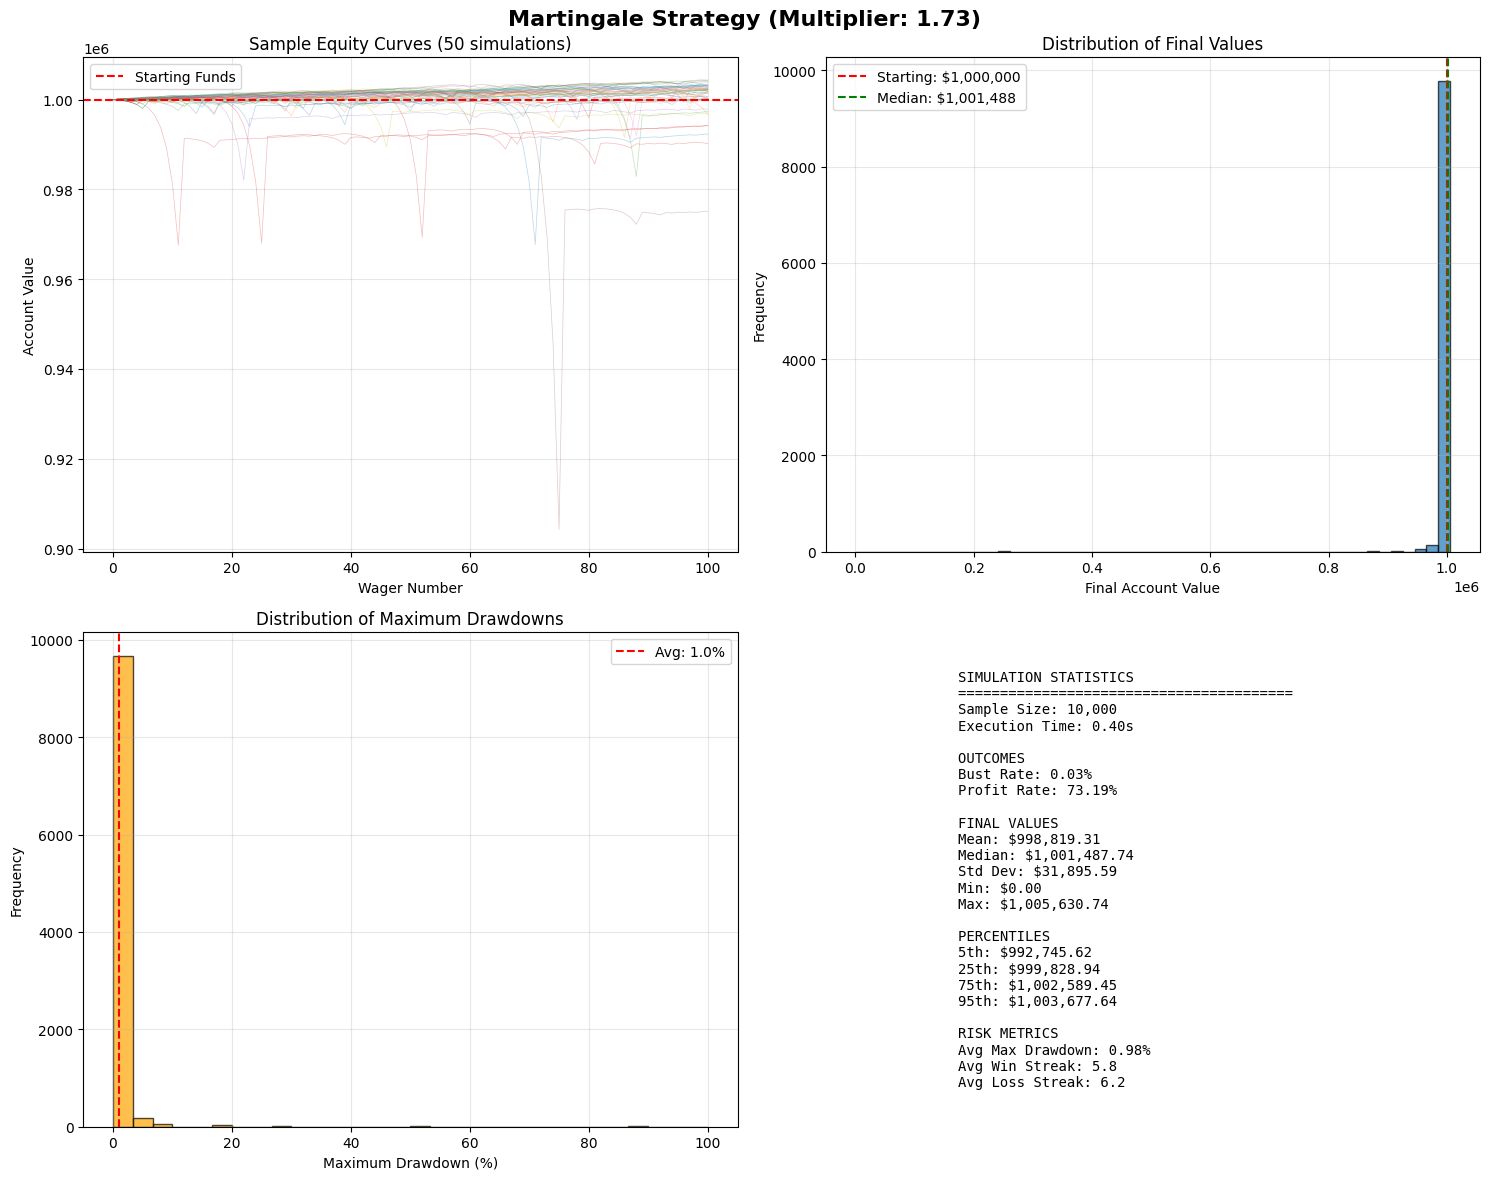

Results exported to simulation_results.csv

OPTIMIZING MULTIPLIER
Testing 10 different multipliers from 1.5 to 4.0...
Multiplier: 1.50 | Bust: 0.00% | Profit: 57.40% | Score: 57.40
Multiplier: 1.78 | Bust: 0.12% | Profit: 78.20% | Score: 78.08
Multiplier: 2.06 | Bust: 0.62% | Profit: 96.92% | Score: 96.30
Multiplier: 2.33 | Bust: 1.27% | Profit: 96.05% | Score: 94.78
Multiplier: 2.61 | Bust: 2.78% | Profit: 93.67% | Score: 90.89
Multiplier: 2.89 | Bust: 5.44% | Profit: 88.58% | Score: 83.14
Multiplier: 3.17 | Bust: 10.03% | Profit: 89.15% | Score: 79.12
Multiplier: 3.44 | Bust: 10.47% | Profit: 81.21% | Score: 70.74
Multiplier: 3.72 | Bust: 18.51% | Profit: 80.50% | Score: 61.99
Multiplier: 4.00 | Bust: 18.92% | Profit: 77.09% | Score: 58.17

Best multiplier found: 2.056
Best score: 96.30


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import time


@dataclass
class SimulationConfig:
    """Configuration parameters for the simulation"""
    starting_funds: float = 1000000
    wager_size: float = 100
    wager_count: int = 100
    sample_size: int = 10000
    lower_bust_threshold: float = 31.235
    higher_profit_threshold: float = 63.208
    win_probability: float = 0.49  # 49% (rolls 51-99 out of 100)


class BettingSimulator:
    """Monte Carlo betting simulation with multiple strategies"""
    
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.results = {
            'busts': 0,
            'profits': 0,
            'final_values': [],
            'max_drawdowns': [],
            'win_streaks': [],
            'loss_streaks': []
        }
    
    def roll_dice(self) -> bool:
        """
        Simulate a dice roll with 49% win probability
        Returns: True if win (51-99), False if loss (1-50, 100)
        """
        roll = random.randint(1, 100)
        return 100 > roll > 50
    
    def roll_dice_vectorized(self, size: int) -> np.ndarray:
        """
        Vectorized dice rolls for performance
        Returns: Boolean array of wins/losses
        """
        rolls = np.random.randint(1, 101, size=size)
        return (rolls > 50) & (rolls < 100)
    
    def calculate_max_drawdown(self, values: List[float]) -> float:
        """Calculate maximum drawdown from peak"""
        if not values:
            return 0
        peak = values[0]
        max_dd = 0
        for value in values:
            if value > peak:
                peak = value
            dd = (peak - value) / peak * 100
            if dd > max_dd:
                max_dd = dd
        return max_dd
    
    def calculate_streaks(self, results: List[bool]) -> Tuple[int, int]:
        """Calculate longest win and loss streaks"""
        max_win_streak = 0
        max_loss_streak = 0
        current_win_streak = 0
        current_loss_streak = 0
        
        for result in results:
            if result:
                current_win_streak += 1
                current_loss_streak = 0
                max_win_streak = max(max_win_streak, current_win_streak)
            else:
                current_loss_streak += 1
                current_win_streak = 0
                max_loss_streak = max(max_loss_streak, current_loss_streak)
        
        return max_win_streak, max_loss_streak
    
    def simple_bettor(self) -> Dict:
        """Simple fixed-bet strategy"""
        value = self.config.starting_funds
        wager = self.config.wager_size
        values = [value]
        results = []
        
        for _ in range(self.config.wager_count):
            won = self.roll_dice()
            results.append(won)
            if won:
                value += wager
            else:
                value -= wager
            values.append(value)
            
            if value <= 0:
                break
        
        max_win, max_loss = self.calculate_streaks(results)
        
        return {
            'final_value': value,
            'values': values,
            'max_drawdown': self.calculate_max_drawdown(values),
            'max_win_streak': max_win,
            'max_loss_streak': max_loss,
            'busted': value <= 0,
            'profitable': value > self.config.starting_funds
        }
    
    def martingale_bettor(self, multiplier: float = 2.0) -> Dict:
        """
        Martingale-style betting with configurable multiplier
        Args:
            multiplier: Amount to multiply bet after loss (default: 2.0 for classic martingale)
        """
        value = self.config.starting_funds
        wager = self.config.wager_size
        initial_wager = self.config.wager_size
        values = [value]
        previous_wager = 'win'
        previous_wager_amount = initial_wager
        results = []
        
        for _ in range(self.config.wager_count):
            if previous_wager == 'win':
                won = self.roll_dice()
                results.append(won)
                if won:
                    value += wager
                else:
                    value -= wager
                    previous_wager = 'lose'
                    previous_wager_amount = wager
                    
            else:  # previous_wager == 'lose'
                won = self.roll_dice()
                results.append(won)
                wager = min(previous_wager_amount * multiplier, value)
                
                if won:
                    value += wager
                    wager = initial_wager
                    previous_wager = 'win'
                else:
                    value -= wager
                    previous_wager = 'lose'
                    previous_wager_amount = wager
            
            values.append(value)
            
            if value <= 0:
                break
        
        max_win, max_loss = self.calculate_streaks(results)
        
        return {
            'final_value': value,
            'values': values,
            'max_drawdown': self.calculate_max_drawdown(values),
            'max_win_streak': max_win,
            'max_loss_streak': max_loss,
            'busted': value <= 0,
            'profitable': value > self.config.starting_funds
        }
    
    def run_simulation(self, strategy: str = 'martingale', multiplier: float = 2.0) -> Dict:
        """Run single simulation with specified strategy"""
        if strategy == 'simple':
            return self.simple_bettor()
        elif strategy == 'martingale':
            return self.martingale_bettor(multiplier)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
    
    def run_monte_carlo(self, strategy: str = 'martingale', multiplier: float = 2.0, 
                       use_parallel: bool = False) -> Dict:
        """
        Run Monte Carlo simulation
        Args:
            strategy: 'simple' or 'martingale'
            multiplier: Bet multiplier after loss (for martingale)
            use_parallel: Use multiprocessing for speedup
        """
        start_time = time.time()
        
        results = {
            'busts': 0,
            'profits': 0,
            'final_values': [],
            'max_drawdowns': [],
            'win_streaks': [],
            'loss_streaks': [],
            'equity_curves': []
        }
        
        for i in range(self.config.sample_size):
            sim_result = self.run_simulation(strategy, multiplier)
            
            results['final_values'].append(sim_result['final_value'])
            results['max_drawdowns'].append(sim_result['max_drawdown'])
            results['win_streaks'].append(sim_result['max_win_streak'])
            results['loss_streaks'].append(sim_result['max_loss_streak'])
            
            if sim_result['busted']:
                results['busts'] += 1
            if sim_result['profitable']:
                results['profits'] += 1
            
            # Store first 100 equity curves for visualization
            if i < 100:
                results['equity_curves'].append(sim_result['values'])
        
        elapsed_time = time.time() - start_time
        
        # Calculate statistics
        final_values = np.array(results['final_values'])
        results['statistics'] = {
            'mean': np.mean(final_values),
            'median': np.median(final_values),
            'std': np.std(final_values),
            'min': np.min(final_values),
            'max': np.max(final_values),
            'percentile_5': np.percentile(final_values, 5),
            'percentile_25': np.percentile(final_values, 25),
            'percentile_75': np.percentile(final_values, 75),
            'percentile_95': np.percentile(final_values, 95),
            'bust_rate': (results['busts'] / self.config.sample_size) * 100,
            'profit_rate': (results['profits'] / self.config.sample_size) * 100,
            'avg_max_drawdown': np.mean(results['max_drawdowns']),
            'avg_win_streak': np.mean(results['win_streaks']),
            'avg_loss_streak': np.mean(results['loss_streaks']),
            'execution_time': elapsed_time
        }
        
        return results
    
    def optimize_multiplier(self, min_mult: float = 1.1, max_mult: float = 5.0, 
                           steps: int = 20) -> Dict:
        """
        Find optimal multiplier by testing range of values
        Args:
            min_mult: Minimum multiplier to test
            max_mult: Maximum multiplier to test
            steps: Number of values to test
        """
        multipliers = np.linspace(min_mult, max_mult, steps)
        best_multiplier = None
        best_score = float('-inf')
        all_results = []
        
        print(f"Testing {steps} different multipliers from {min_mult} to {max_mult}...")
        
        for mult in multipliers:
            results = self.run_monte_carlo('martingale', mult)
            stats = results['statistics']
            
            # Score based on profit rate minus bust rate
            score = stats['profit_rate'] - stats['bust_rate']
            
            all_results.append({
                'multiplier': mult,
                'bust_rate': stats['bust_rate'],
                'profit_rate': stats['profit_rate'],
                'score': score,
                'median_final': stats['median']
            })
            
            if score > best_score:
                best_score = score
                best_multiplier = mult
            
            print(f"Multiplier: {mult:.2f} | Bust: {stats['bust_rate']:.2f}% | "
                  f"Profit: {stats['profit_rate']:.2f}% | Score: {score:.2f}")
        
        return {
            'best_multiplier': best_multiplier,
            'best_score': best_score,
            'all_results': all_results
        }
    
    def plot_results(self, results: Dict, title: str = "Monte Carlo Simulation Results"):
        """Create comprehensive visualization of results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Equity curves
        ax1 = axes[0, 0]
        for curve in results['equity_curves'][:50]:  # Plot first 50
            ax1.plot(curve, alpha=0.3, linewidth=0.5)
        ax1.axhline(y=self.config.starting_funds, color='r', linestyle='--', label='Starting Funds')
        ax1.set_xlabel('Wager Number')
        ax1.set_ylabel('Account Value')
        ax1.set_title('Sample Equity Curves (50 simulations)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Final value distribution
        ax2 = axes[0, 1]
        ax2.hist(results['final_values'], bins=50, edgecolor='black', alpha=0.7)
        ax2.axvline(x=self.config.starting_funds, color='r', linestyle='--', 
                   label=f'Starting: ${self.config.starting_funds:,.0f}')
        ax2.axvline(x=results['statistics']['median'], color='g', linestyle='--',
                   label=f'Median: ${results["statistics"]["median"]:,.0f}')
        ax2.set_xlabel('Final Account Value')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distribution of Final Values')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Drawdown distribution
        ax3 = axes[1, 0]
        ax3.hist(results['max_drawdowns'], bins=30, edgecolor='black', alpha=0.7, color='orange')
        ax3.axvline(x=results['statistics']['avg_max_drawdown'], color='r', linestyle='--',
                   label=f'Avg: {results["statistics"]["avg_max_drawdown"]:.1f}%')
        ax3.set_xlabel('Maximum Drawdown (%)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Distribution of Maximum Drawdowns')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Statistics summary
        ax4 = axes[1, 1]
        ax4.axis('off')
        stats = results['statistics']
        summary_text = f"""
        SIMULATION STATISTICS
        {'='*40}
        Sample Size: {self.config.sample_size:,}
        Execution Time: {stats['execution_time']:.2f}s
        
        OUTCOMES
        Bust Rate: {stats['bust_rate']:.2f}%
        Profit Rate: {stats['profit_rate']:.2f}%
        
        FINAL VALUES
        Mean: ${stats['mean']:,.2f}
        Median: ${stats['median']:,.2f}
        Std Dev: ${stats['std']:,.2f}
        Min: ${stats['min']:,.2f}
        Max: ${stats['max']:,.2f}
        
        PERCENTILES
        5th: ${stats['percentile_5']:,.2f}
        25th: ${stats['percentile_25']:,.2f}
        75th: ${stats['percentile_75']:,.2f}
        95th: ${stats['percentile_95']:,.2f}
        
        RISK METRICS
        Avg Max Drawdown: {stats['avg_max_drawdown']:.2f}%
        Avg Win Streak: {stats['avg_win_streak']:.1f}
        Avg Loss Streak: {stats['avg_loss_streak']:.1f}
        """
        ax4.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
                verticalalignment='center')
        
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('monte_carlo_results.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def export_to_csv(self, results: Dict, filename: str = 'simulation_results.csv'):
        """Export simulation results to CSV"""
        df = pd.DataFrame({
            'final_value': results['final_values'],
            'max_drawdown': results['max_drawdowns'],
            'max_win_streak': results['win_streaks'],
            'max_loss_streak': results['loss_streaks']
        })
        df.to_csv(filename, index=False)
        print(f"Results exported to {filename}")


def main():
    """Main execution function"""
    
    # Initialize configuration
    config = SimulationConfig(
        starting_funds=1000000,
        wager_size=100,
        wager_count=100,
        sample_size=10000,
        lower_bust_threshold=31.235,
        higher_profit_threshold=63.208
    )
    
    # Create simulator
    simulator = BettingSimulator(config)
    
    print("="*60)
    print("MONTE CARLO BETTING SIMULATION")
    print("="*60)
    
    # Test single random multiplier (original behavior)
    random_multiplier = random.uniform(1.5, 3.5)
    print(f"\nTesting random multiplier: {random_multiplier:.3f}")
    print("-"*60)
    
    results = simulator.run_monte_carlo('martingale', random_multiplier)
    stats = results['statistics']
    
    print(f"\nBust Rate: {stats['bust_rate']:.2f}%")
    print(f"Profit Rate: {stats['profit_rate']:.2f}%")
    print(f"Median Final Value: ${stats['median']:,.2f}")
    print(f"Execution Time: {stats['execution_time']:.2f}s")
    
    # Check against thresholds
    if stats['bust_rate'] < config.lower_bust_threshold and \
       stats['profit_rate'] > config.higher_profit_threshold:
        print(f"\n{'='*60}")
        print(f"✓ WINNER FOUND!")
        print(f"  Multiplier: {random_multiplier:.3f}")
        print(f"  Bust Rate: {stats['bust_rate']:.2f}% (target: <{config.lower_bust_threshold}%)")
        print(f"  Profit Rate: {stats['profit_rate']:.2f}% (target: >{config.higher_profit_threshold}%)")
        print(f"{'='*60}")
    else:
        print(f"\n{'='*60}")
        print(f"✗ Did not meet thresholds")
        print(f"  Multiplier: {random_multiplier:.3f}")
        print(f"  Bust Rate: {stats['bust_rate']:.2f}% (target: <{config.lower_bust_threshold}%)")
        print(f"  Profit Rate: {stats['profit_rate']:.2f}% (target: >{config.higher_profit_threshold}%)")
        print(f"{'='*60}")
    
    # Plot results
    simulator.plot_results(results, f"Martingale Strategy (Multiplier: {random_multiplier:.2f})")
    
    # Export results
    simulator.export_to_csv(results)
    
  
    print("\n" + "="*60)
    print("OPTIMIZING MULTIPLIER")
    print("="*60)
    optimization_results = simulator.optimize_multiplier(min_mult=1.5, max_mult=4.0, steps=10)
    print(f"\nBest multiplier found: {optimization_results['best_multiplier']:.3f}")
    print(f"Best score: {optimization_results['best_score']:.2f}")


if __name__ == "__main__":
    main()
